In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [10]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';')

In [11]:
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [ ]:
# запустим AA тест

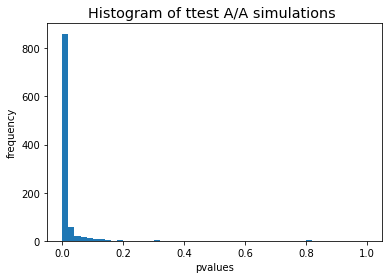

0.929

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Видим значимые различия между группами

In [14]:
df.groupby(['experimentVariant', 'version'], as_index=False).agg({'purchase' : 'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Из данной группировки видно, что конверсия между группами сильно различается в версии v2.8.0, возможно у пользователей со старой версией имеются какие-то проблемы с приложением. Применим t-тест, чтобы выявить значимые различия между группами 

In [21]:
stats.ttest_ind(df[(df.experimentVariant == 1) & (df.version == 'v2.8.0')]['purchase'], 
                df[(df.experimentVariant == 0) & (df.version == 'v2.8.0')]['purchase'])

Ttest_indResult(statistic=42.963540840360324, pvalue=0.0)

In [22]:
stats.ttest_ind(df[(df.experimentVariant == 1) & (df.version == 'v2.9.0')]['purchase'], 
                df[(df.experimentVariant == 0) & (df.version == 'v2.9.0')]['purchase'])

Ttest_indResult(statistic=-0.9979597634962479, pvalue=0.31830895167207446)

In [23]:
stats.ttest_ind(df[(df.experimentVariant == 1) & (df.version == 'v3.7.4.0')]['purchase'], 
                df[(df.experimentVariant == 0) & (df.version == 'v3.7.4.0')]['purchase'])

Ttest_indResult(statistic=0.5874925850487471, pvalue=0.5568886771079735)

In [24]:
stats.ttest_ind(df[(df.experimentVariant == 1) & (df.version == 'v3.8.0.0')]['purchase'], 
                df[(df.experimentVariant == 0) & (df.version == 'v3.8.0.0')]['purchase'])

Ttest_indResult(statistic=1.1956188950206779, pvalue=0.23186933664059722)

Действительно с помощью t-тестов значимые различия между группами выявлены только при использовании версии v2.8.0, исключим ее из запуска симуляций А/А теста 

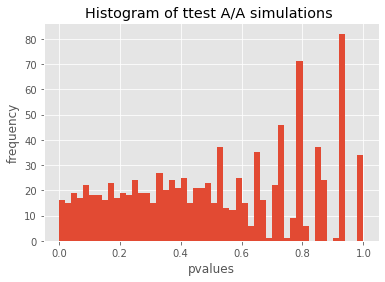

0.041

In [19]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

При повторном запуске симуляций А/А теста мы получили FPR меньше 0.05, что подтвердило гипотезу о том, что у пользователей со старой версией имеются некоторые проблемы с приложением. 